<Figure size 1000x600 with 0 Axes>

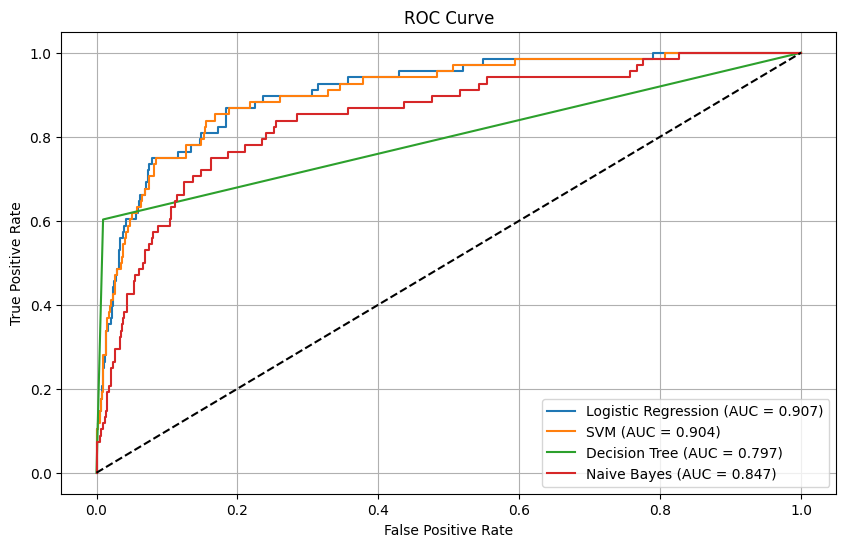

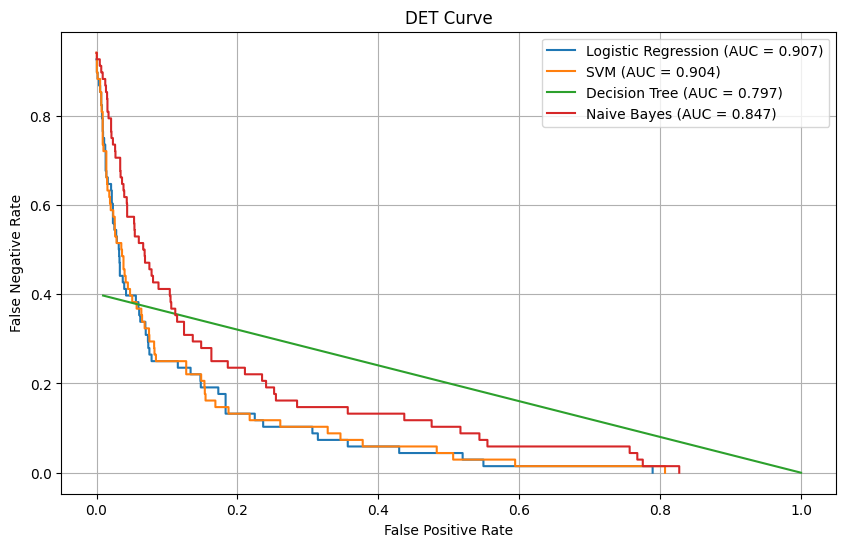

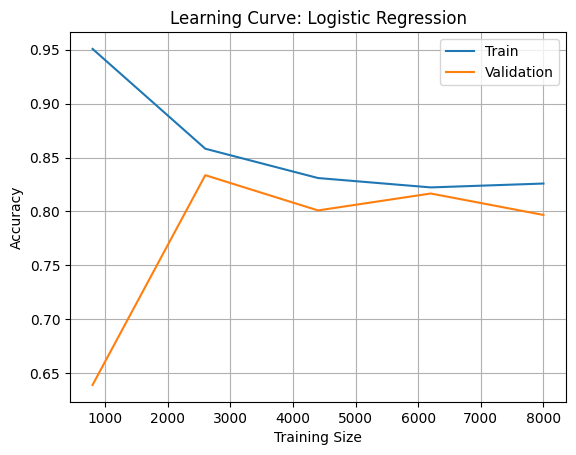

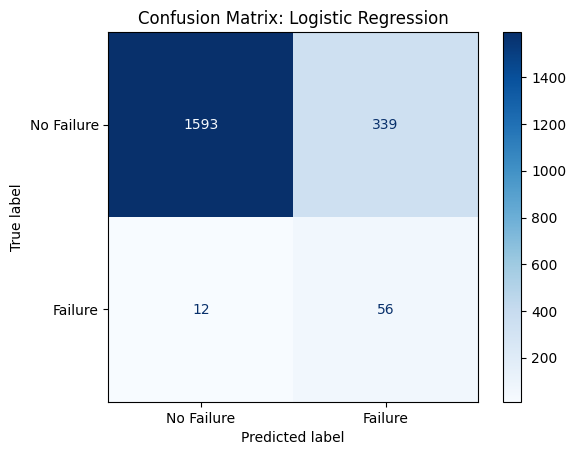

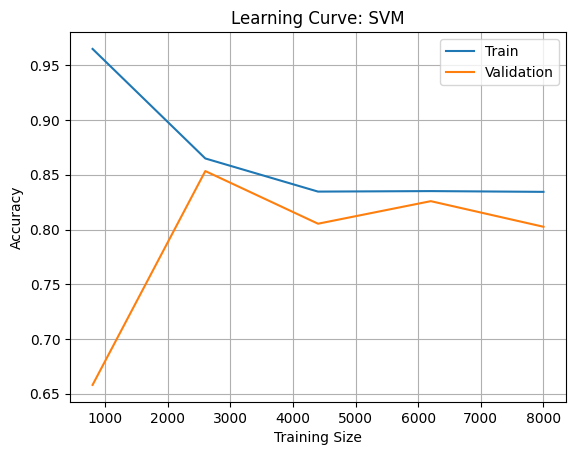

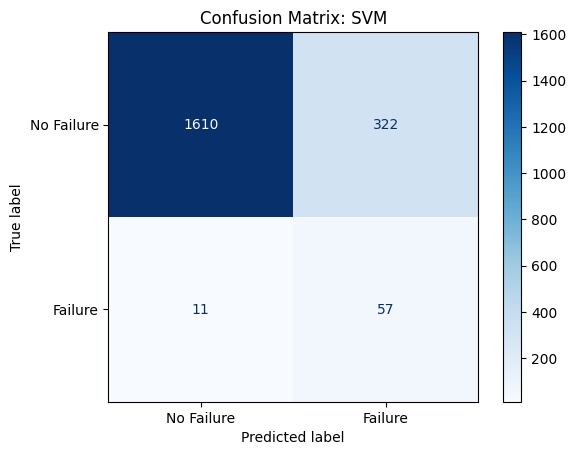

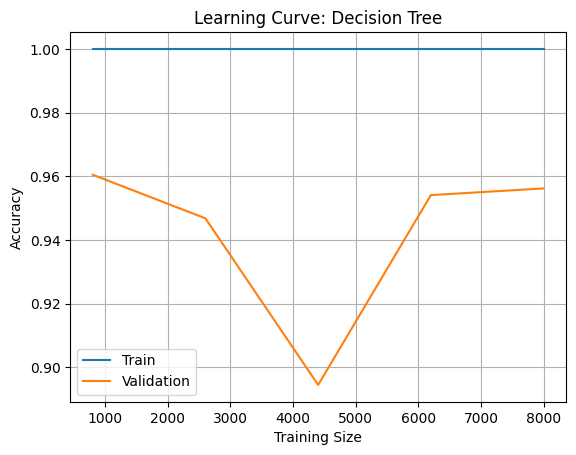

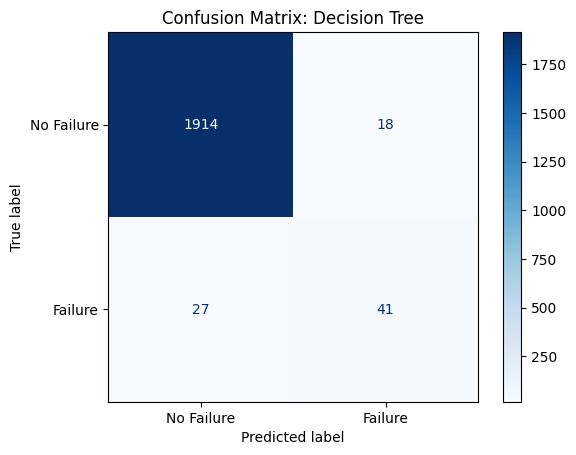

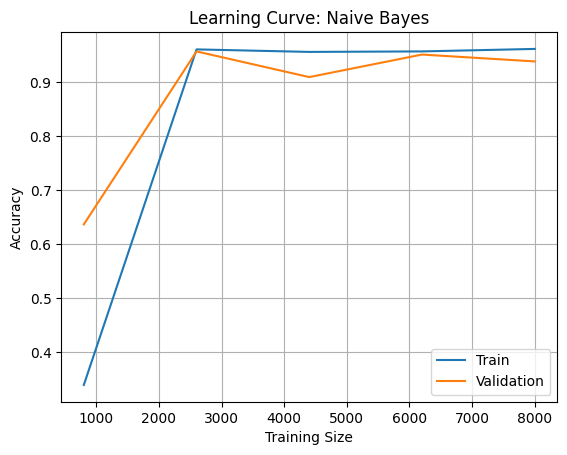

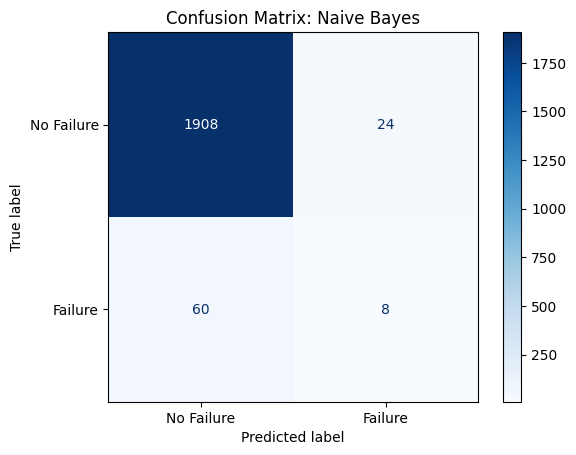


--- Evaluation Summary ---
                     Accuracy  F1 Score  Precision    Recall  Specificity  \
Logistic Regression    0.8245  0.241901   0.141772  0.823529     0.824534   
SVM                    0.8335  0.255034   0.150396  0.838235     0.833333   
Decision Tree          0.9775  0.645669   0.694915  0.602941     0.990683   
Naive Bayes            0.9580  0.160000   0.250000  0.117647     0.987578   

                          AUC  Log Loss       MCC     Kappa  \
Logistic Regression  0.906954  0.384236  0.295012  0.195213   
SVM                  0.904001  0.099345  0.310554  0.209454   
Decision Tree        0.796812  0.810982  0.635815  0.634111   
Naive Bayes          0.846814  0.143416  0.151981  0.141315   

                     Misclassification Error  
Logistic Regression                   0.1755  
SVM                                   0.1665  
Decision Tree                         0.0225  
Naive Bayes                           0.0420  


In [1]:
# --- STEP 1: Imports ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, learning_curve
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.metrics import (
    accuracy_score, f1_score, precision_score, recall_score,
    roc_auc_score, classification_report, roc_curve, det_curve,
    confusion_matrix, ConfusionMatrixDisplay, log_loss,
    matthews_corrcoef, cohen_kappa_score
)

# --- STEP 2: Load and Prepare Data ---
df = pd.read_csv("file2.csv")

df = df.drop(columns=["UDI", "Product ID", "TWF", "HDF", "PWF", "OSF", "RNF"], errors="ignore")

X = df.drop(columns=["Machine failure"])
y = df["Machine failure"]

# --- STEP 3: Identify Column Types ---
categorical_cols = X.select_dtypes(include=["object"]).columns.tolist()
numerical_cols = X.select_dtypes(include=["int64", "float64"]).columns.tolist()

# --- STEP 4: Build Preprocessing Pipeline ---
numeric_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer([
    ("num", numeric_pipeline, numerical_cols),
    ("cat", categorical_pipeline, categorical_cols)
])

# --- STEP 5: Train/Test Split ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# --- STEP 6: Define Models ---
models = {
    "Logistic Regression": LogisticRegression(class_weight="balanced", random_state=42),
    "SVM": SVC(kernel='linear', class_weight="balanced", probability=True, random_state=42),
    "Decision Tree": DecisionTreeClassifier(class_weight="balanced", random_state=42),
    "Naive Bayes": GaussianNB()
}

# --- STEP 7: Train, Predict, Evaluate ---
results = {}

plt.figure(figsize=(10, 6))
for name, model in models.items():
    pipeline = Pipeline([
        ("preprocessor", preprocessor),
        ("classifier", model)
    ])
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    y_proba = pipeline.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else pipeline.decision_function(X_test)

    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()

    # Metrics
    results[name] = {
        "model": pipeline,
        "accuracy": accuracy_score(y_test, y_pred),
        "f1": f1_score(y_test, y_pred),
        "precision": precision_score(y_test, y_pred),
        "recall": recall_score(y_test, y_pred),
        "auc": roc_auc_score(y_test, y_proba),
        "log_loss": log_loss(y_test, y_proba),
        "specificity": tn / (tn + fp) if (tn + fp) > 0 else 0,
        "mcc": matthews_corrcoef(y_test, y_pred),
        "kappa": cohen_kappa_score(y_test, y_pred),
        "misclassification_error": (fp + fn) / (tp + tn + fp + fn),
        "y_pred": y_pred,
        "y_proba": y_proba
    }

# --- STEP 8: ROC Curve ---
plt.figure(figsize=(10, 6))
for name, res in results.items():
    fpr, tpr, _ = roc_curve(y_test, res["y_proba"])
    plt.plot(fpr, tpr, label=f"{name} (AUC = {res['auc']:.3f})")

plt.plot([0, 1], [0, 1], 'k--')
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid()
plt.show()

# --- STEP 9: DET Curve ---
plt.figure(figsize=(10, 6))
for name, res in results.items():
    fpr, fnr, _ = det_curve(y_test, res["y_proba"])
    plt.plot(fpr, fnr, label=f"{name} (AUC = {res['auc']:.3f})")

plt.title("DET Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("False Negative Rate")
plt.legend()
plt.grid()
plt.show()

# --- STEP 10: Learning Curves and Confusion Matrices ---
for name, res in results.items():
    model = res["model"]
    train_sizes, train_scores, test_scores = learning_curve(
        model, X, y, cv=5, scoring='accuracy', train_sizes=np.linspace(0.1, 1.0, 5)
    )
    plt.figure()
    plt.plot(train_sizes, train_scores.mean(axis=1), label="Train")
    plt.plot(train_sizes, test_scores.mean(axis=1), label="Validation")
    plt.title(f"Learning Curve: {name}")
    plt.xlabel("Training Size")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid()
    plt.show()

    ConfusionMatrixDisplay.from_predictions(y_test, res["y_pred"], display_labels=["No Failure", "Failure"], cmap="Blues")
    plt.title(f"Confusion Matrix: {name}")
    plt.grid(False)
    plt.show()

# --- STEP 11: Summary Table ---
summary_df = pd.DataFrame({
    model: {
        "Accuracy": res["accuracy"],
        "F1 Score": res["f1"],
        "Precision": res["precision"],
        "Recall": res["recall"],
        "Specificity": res["specificity"],
        "AUC": res["auc"],
        "Log Loss": res["log_loss"],
        "MCC": res["mcc"],
        "Kappa": res["kappa"],
        "Misclassification Error": res["misclassification_error"]
    }
    for model, res in results.items()
}).T

print("\n--- Evaluation Summary ---")
print(summary_df)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Training LSTM...
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


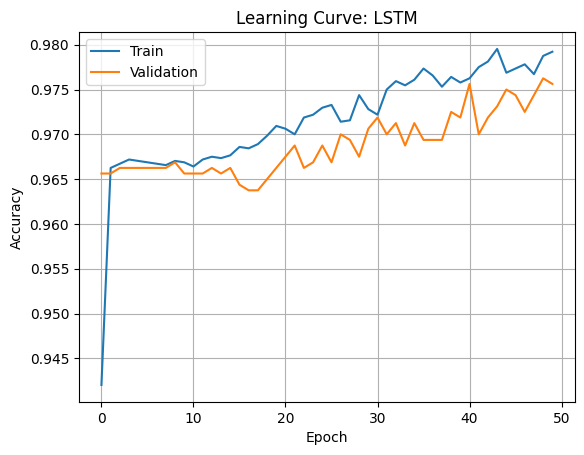

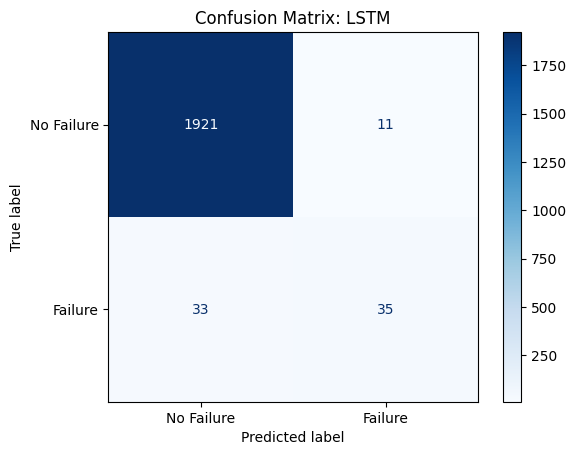


Training 1D CNN...
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


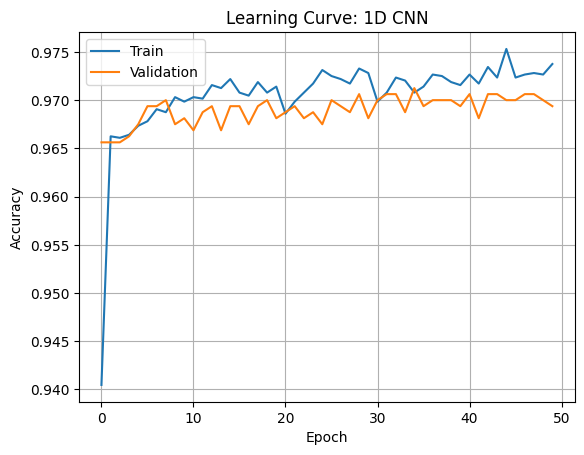

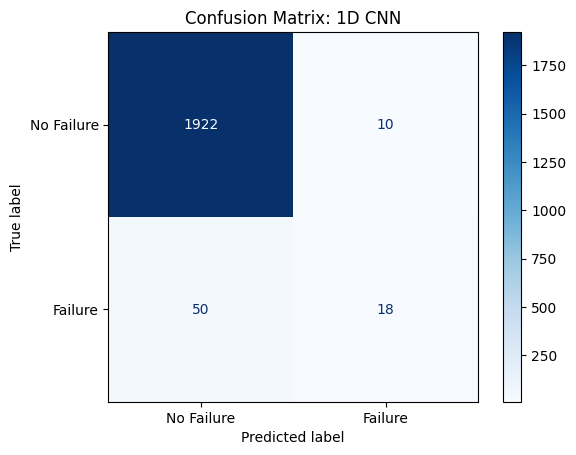


Training Transformer...
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


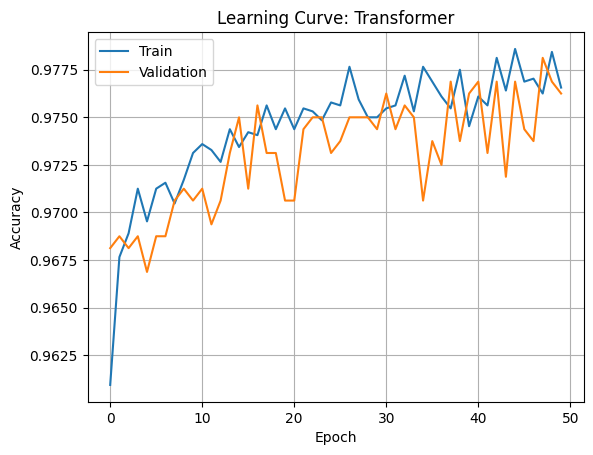

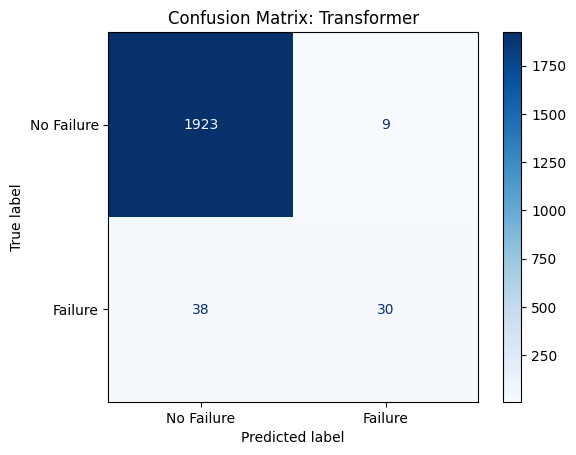

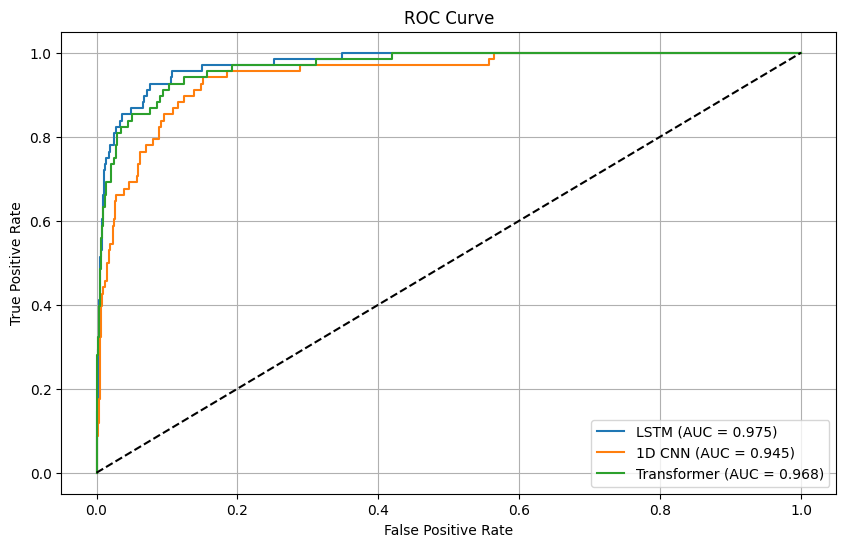

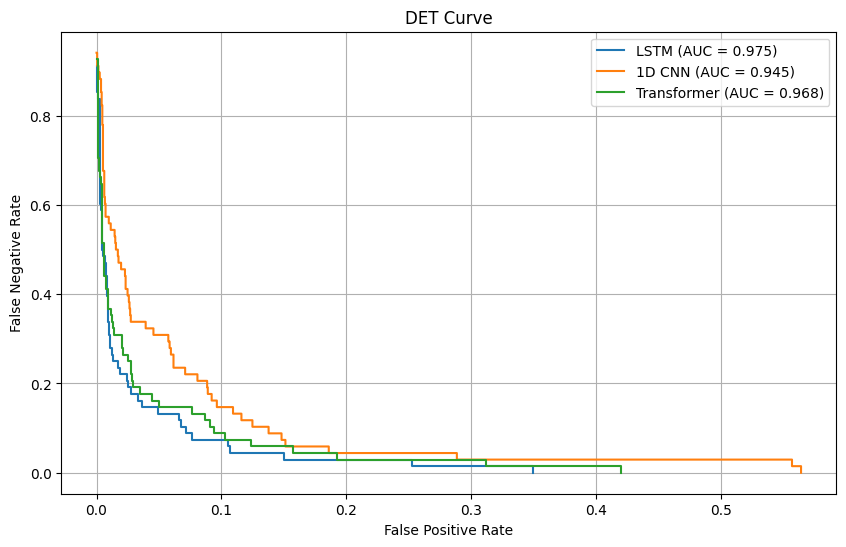


--- Deep Learning Evaluation Summary ---
             Accuracy  F1 Score  Precision    Recall  Specificity       AUC  \
LSTM           0.9780  0.614035   0.760870  0.514706     0.994306  0.974790   
1D CNN         0.9700  0.375000   0.642857  0.264706     0.994824  0.945287   
Transformer    0.9765  0.560748   0.769231  0.441176     0.995342  0.968000   

             Log Loss       MCC     Kappa  Misclassification Error  
LSTM         0.060084  0.615382  0.603146                   0.0220  
1D CNN       0.083947  0.400325  0.362353                   0.0300  
Transformer  0.066988  0.572123  0.549584                   0.0235  


In [3]:
# --- STEP 1: Preprocess ---
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

X_train_seq = X_train_processed.reshape((X_train_processed.shape[0], X_train_processed.shape[1], 1))
X_test_seq = X_test_processed.reshape((X_test_processed.shape[0], X_test_processed.shape[1], 1))
input_shape = X_train_seq.shape[1:]

# --- STEP 2: Deep Learning Imports ---
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (
    Dense, Dropout, Conv1D, MaxPooling1D, Flatten, LSTM, Input,
    LayerNormalization, MultiHeadAttention, GlobalAveragePooling1D, Reshape
)
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.metrics import (
    accuracy_score, f1_score, precision_score, recall_score, roc_auc_score,
    roc_curve, det_curve, ConfusionMatrixDisplay, confusion_matrix,
    log_loss, matthews_corrcoef, cohen_kappa_score
)

# --- STEP 3: Define Deep Models ---
def build_mlp(input_dim):
    model = Sequential([
        Dense(64, activation='relu', input_shape=(input_dim,)),
        Dropout(0.3),
        Dense(32, activation='relu'),
        Dropout(0.2),
        Dense(1, activation='sigmoid')
    ])
    return model

def build_lstm(input_shape):
    model = Sequential([
        LSTM(32, input_shape=input_shape),
        Dropout(0.3),
        Dense(1, activation='sigmoid')
    ])
    return model

def build_cnn(input_shape):
    model = Sequential([
        Conv1D(32, kernel_size=3, activation='relu', input_shape=input_shape),
        MaxPooling1D(pool_size=2),
        Flatten(),
        Dropout(0.3),
        Dense(1, activation='sigmoid')
    ])
    return model

def build_transformer(input_dim):
    inputs = Input(shape=(input_dim,))
    x = Reshape((1, input_dim))(inputs)
    x = Dense(64)(x)
    x = MultiHeadAttention(num_heads=2, key_dim=16)(x, x)
    x = LayerNormalization()(x)
    x = GlobalAveragePooling1D()(x)
    x = Dropout(0.2)(x)
    outputs = Dense(1, activation='sigmoid')(x)
    return Model(inputs, outputs)

models = {
   # "MLP": build_mlp(X_train_processed.shape[1]),
    "LSTM": build_lstm(input_shape),
    "1D CNN": build_cnn(input_shape),
    "Transformer": build_transformer(X_train_processed.shape[1])
}

# --- STEP 4: Train and Evaluate ---
results = {}

for name, model in models.items():
    print(f"\nTraining {name}...")
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    history = model.fit(
        X_train_processed if name == "MLP" else X_train_seq,
        y_train,
        epochs=50,
        batch_size=32,
        validation_split=0.2,
        verbose=0,
        callbacks=[EarlyStopping(patience=10, restore_best_weights=True)]
    )

    X_eval = X_test_processed if name == "MLP" else X_test_seq
    y_proba = model.predict(X_eval).ravel()
    y_pred = (y_proba >= 0.5).astype(int)

    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()

    results[name] = {
        "model": model,
        "accuracy": accuracy_score(y_test, y_pred),
        "f1": f1_score(y_test, y_pred),
        "precision": precision_score(y_test, y_pred),
        "recall": recall_score(y_test, y_pred),
        "auc": roc_auc_score(y_test, y_proba),
        "log_loss": log_loss(y_test, y_proba),
        "specificity": tn / (tn + fp) if (tn + fp) > 0 else 0,
        "mcc": matthews_corrcoef(y_test, y_pred),
        "kappa": cohen_kappa_score(y_test, y_pred),
        "misclassification_error": (fp + fn) / (tp + tn + fp + fn),
        "y_pred": y_pred,
        "y_proba": y_proba,
        "history": history
    }

    plt.figure()
    plt.plot(history.history['accuracy'], label='Train')
    plt.plot(history.history['val_accuracy'], label='Validation')
    plt.title(f"Learning Curve: {name}")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid()
    plt.show()

    ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=["No Failure", "Failure"], cmap="Blues")
    plt.title(f"Confusion Matrix: {name}")
    plt.grid(False)
    plt.show()

# --- STEP 5: ROC and DET Curves ---
plt.figure(figsize=(10, 6))
for name, res in results.items():
    fpr, tpr, _ = roc_curve(y_test, res["y_proba"])
    plt.plot(fpr, tpr, label=f"{name} (AUC = {res['auc']:.3f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(10, 6))
for name, res in results.items():
    fpr, fnr, _ = det_curve(y_test, res["y_proba"])
    plt.plot(fpr, fnr, label=f"{name} (AUC = {res['auc']:.3f})")
plt.title("DET Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("False Negative Rate")
plt.legend()
plt.grid()
plt.show()

# --- STEP 6: Summary Table ---
summary = pd.DataFrame({
    name: {
        "Accuracy": res["accuracy"],
        "F1 Score": res["f1"],
        "Precision": res["precision"],
        "Recall": res["recall"],
        "Specificity": res["specificity"],
        "AUC": res["auc"],
        "Log Loss": res["log_loss"],
        "MCC": res["mcc"],
        "Kappa": res["kappa"],
        "Misclassification Error": res["misclassification_error"]
    } for name, res in results.items()
}).T

print("\n--- Deep Learning Evaluation Summary ---")
print(summary)


Training GRU...


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


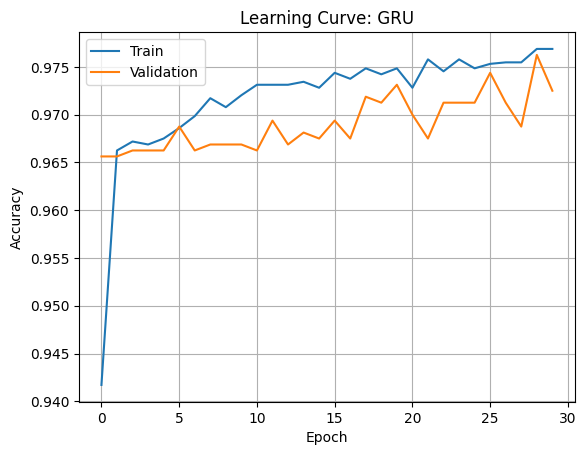

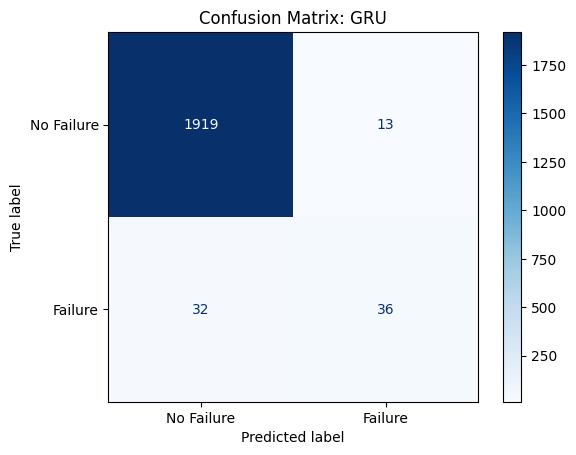


Training Bi-LSTM...
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


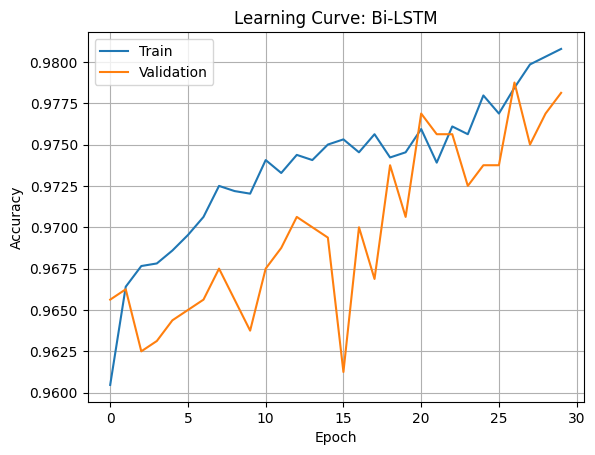

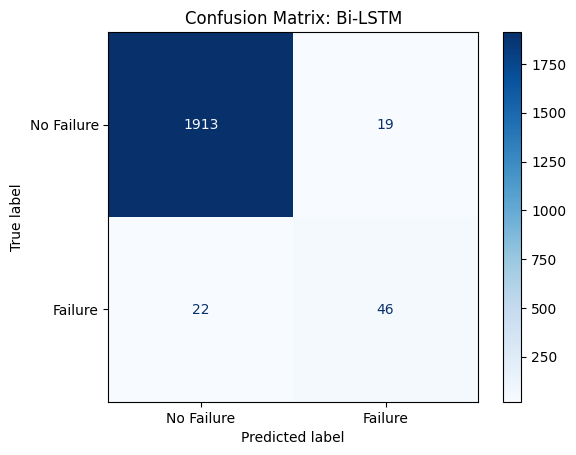

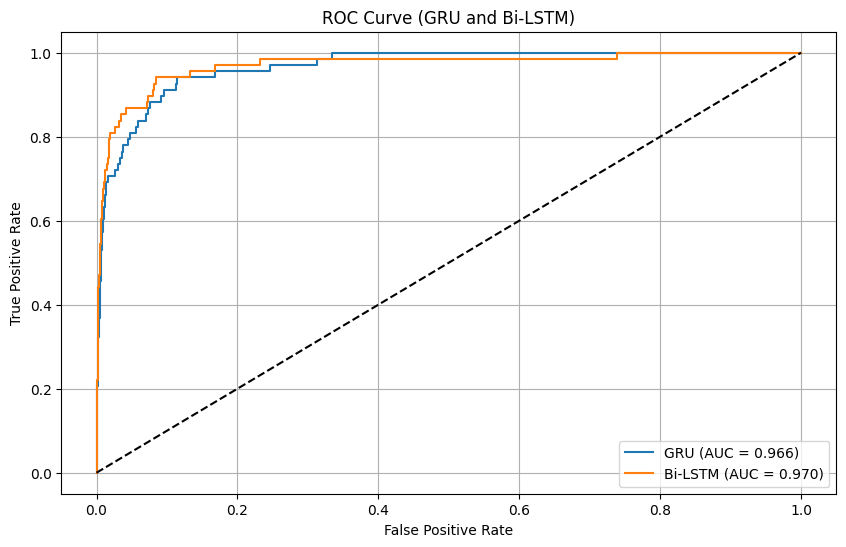

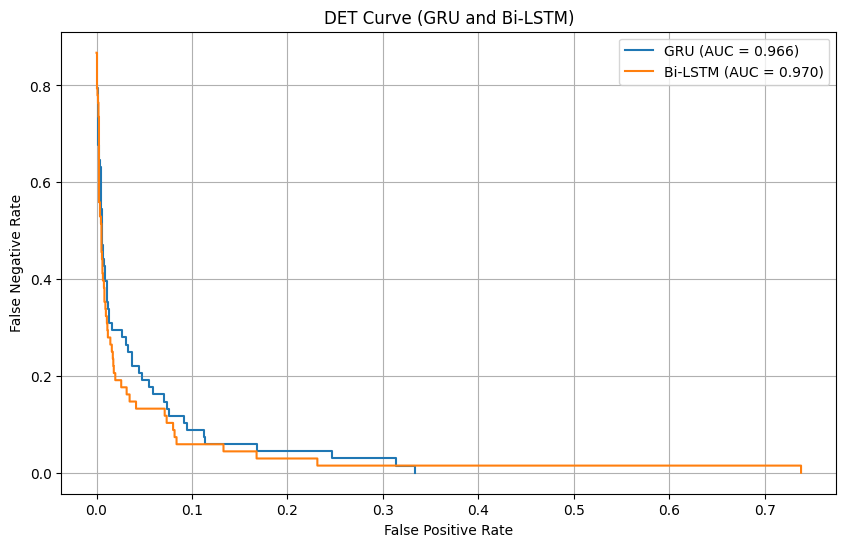


--- Evaluation Summary: GRU and Bi-LSTM ---
         Accuracy  F1 Score  Precision    Recall  Specificity       AUC  \
GRU        0.9775  0.615385   0.734694  0.529412     0.993271  0.966478   
Bi-LSTM    0.9795  0.691729   0.707692  0.676471     0.990166  0.969515   

         Log Loss       MCC     Kappa  Misclassification Error  
GRU      0.067240  0.612731  0.604110                   0.0225  
Bi-LSTM  0.059895  0.681318  0.681132                   0.0205  


In [4]:
# --- STEP 1: GRU/Bi-LSTM Imports ---
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Bidirectional, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.metrics import (
    accuracy_score, f1_score, precision_score, recall_score, roc_auc_score,
    roc_curve, det_curve, ConfusionMatrixDisplay, confusion_matrix,
    log_loss, matthews_corrcoef, cohen_kappa_score
)

import matplotlib.pyplot as plt
import pandas as pd

# --- STEP 2: Define Models ---
def build_gru(input_shape):
    model = Sequential([
        GRU(32, input_shape=input_shape),
        Dropout(0.3),
        Dense(1, activation='sigmoid')
    ])
    return model

def build_bilstm(input_shape):
    model = Sequential([
        Bidirectional(GRU(32), input_shape=input_shape),
        Dropout(0.3),
        Dense(1, activation='sigmoid')
    ])
    return model

# --- STEP 3: Create Model Dictionary ---
input_shape = X_train_seq.shape[1:]
models_combined = {
    "GRU": build_gru(input_shape),
    "Bi-LSTM": build_bilstm(input_shape)
}

# --- STEP 4: Train and Evaluate ---
results_combined = {}

for name, model in models_combined.items():
    print(f"\nTraining {name}...")
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    history = model.fit(
        X_train_seq,
        y_train,
        epochs=30,
        batch_size=32,
        validation_split=0.2,
        verbose=0,
        callbacks=[EarlyStopping(patience=5, restore_best_weights=True)]
    )

    y_proba = model.predict(X_test_seq).ravel()
    y_pred = (y_proba >= 0.5).astype(int)

    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()

    results_combined[name] = {
        "model": model,
        "accuracy": accuracy_score(y_test, y_pred),
        "f1": f1_score(y_test, y_pred),
        "precision": precision_score(y_test, y_pred),
        "recall": recall_score(y_test, y_pred),
        "auc": roc_auc_score(y_test, y_proba),
        "log_loss": log_loss(y_test, y_proba),
        "specificity": tn / (tn + fp) if (tn + fp) > 0 else 0,
        "mcc": matthews_corrcoef(y_test, y_pred),
        "kappa": cohen_kappa_score(y_test, y_pred),
        "misclassification_error": (fp + fn) / (tp + tn + fp + fn),
        "y_pred": y_pred,
        "y_proba": y_proba,
        "history": history
    }

    # Learning Curve
    plt.figure()
    plt.plot(history.history['accuracy'], label='Train')
    plt.plot(history.history['val_accuracy'], label='Validation')
    plt.title(f"Learning Curve: {name}")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid()
    plt.show()

    # Confusion Matrix
    ConfusionMatrixDisplay.from_predictions(
        y_test, y_pred, display_labels=["No Failure", "Failure"], cmap="Blues"
    )
    plt.title(f"Confusion Matrix: {name}")
    plt.grid(False)
    plt.show()

# --- STEP 5: ROC and DET Curves ---
plt.figure(figsize=(10, 6))
for name, res in results_combined.items():
    fpr, tpr, _ = roc_curve(y_test, res["y_proba"])
    plt.plot(fpr, tpr, label=f"{name} (AUC = {res['auc']:.3f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.title("ROC Curve (GRU and Bi-LSTM)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(10, 6))
for name, res in results_combined.items():
    fpr, fnr, _ = det_curve(y_test, res["y_proba"])
    plt.plot(fpr, fnr, label=f"{name} (AUC = {res['auc']:.3f})")
plt.title("DET Curve (GRU and Bi-LSTM)")
plt.xlabel("False Positive Rate")
plt.ylabel("False Negative Rate")
plt.legend()
plt.grid()
plt.show()

# --- STEP 6: Summary Table ---
summary_combined = pd.DataFrame({
    name: {
        "Accuracy": res["accuracy"],
        "F1 Score": res["f1"],
        "Precision": res["precision"],
        "Recall": res["recall"],
        "Specificity": res["specificity"],
        "AUC": res["auc"],
        "Log Loss": res["log_loss"],
        "MCC": res["mcc"],
        "Kappa": res["kappa"],
        "Misclassification Error": res["misclassification_error"]
    } for name, res in results_combined.items()
}).T

print("\n--- Evaluation Summary: GRU and Bi-LSTM ---")
print(summary_combined)


Accuracy: 0.8245

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.82      0.90      1932
           1       0.14      0.82      0.24        68

    accuracy                           0.82      2000
   macro avg       0.57      0.82      0.57      2000
weighted avg       0.96      0.82      0.88      2000



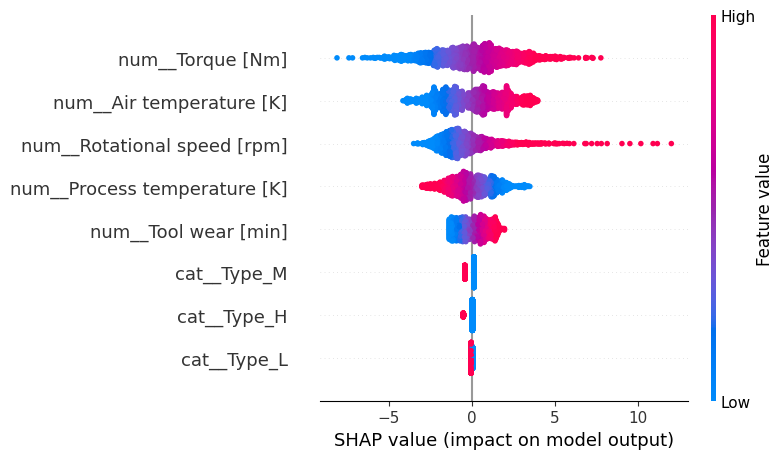

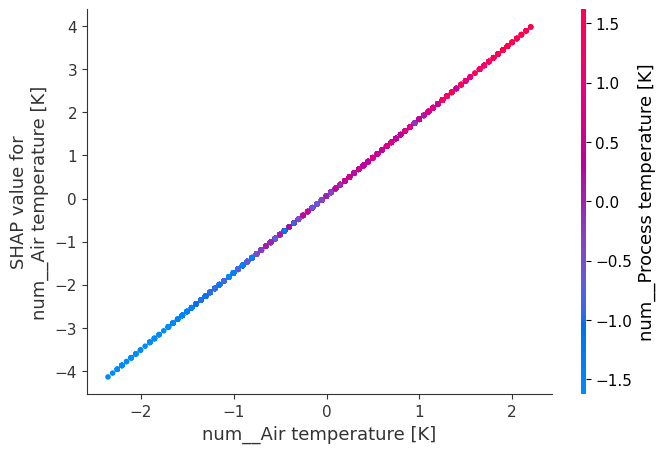

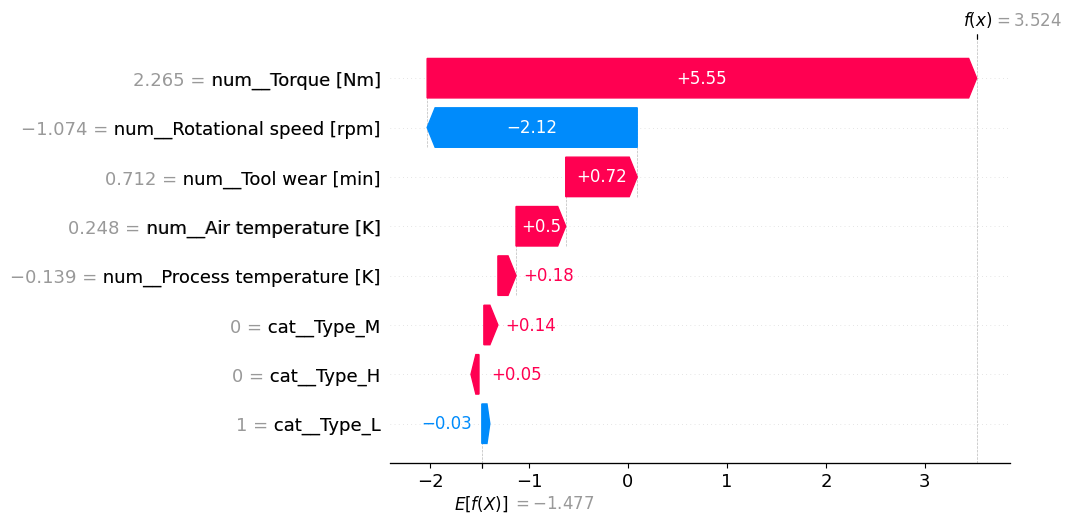

In [5]:
# --- STEP 1: SHAP Imports ---
import shap
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# --- STEP 2: Train Logistic Regression Model ---
clf = LogisticRegression(class_weight="balanced", max_iter=1000)
clf.fit(X_train_processed, y_train)

y_pred = clf.predict(X_test_processed)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# --- STEP 3: Run SHAP ---
explainer = shap.Explainer(clf, X_train_processed)
shap_values = explainer(X_test_processed)

# --- STEP 4: Global Feature Importance ---
shap.summary_plot(
    shap_values,
    X_test_processed,
    feature_names=preprocessor.get_feature_names_out(),
    show=True
)

# --- STEP 5: Local Explanation (Force Plot) ---
shap.initjs()
shap.force_plot(
    explainer.expected_value,
    shap_values[0].values,
    X_test_processed[0],
    feature_names=preprocessor.get_feature_names_out()
)

# --- STEP 6: Dependence Plot ---
feature_names = preprocessor.get_feature_names_out()
shap.dependence_plot("num__Air temperature [K]", shap_values.values, X_test_processed, feature_names=feature_names)

# --- STEP 7: Waterfall Plot ---
def plot_waterfall(shap_values, X_transformed, index, feature_names):
    explanation = shap.Explanation(
        values=shap_values[index].values,
        base_values=shap_values[index].base_values,
        data=X_transformed[index],
        feature_names=feature_names
    )
    shap.plots.waterfall(explanation)

plot_waterfall(shap_values, X_test_processed, 0, feature_names)
